In [163]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [164]:
voice_usage_info = pd.read_csv("data/new/IDD_Outgoing.csv")  # pd.read_csv("data/VOICE_OUTGOING_CALL_USAGE_IDD.csv")
voice_usage_info

,account_num.hash,event_source.hash,ym,outgoing_country,call_count,volume,usage_rev,RTOM_CODE,LOCATION_CODE,MSAN,EQUP_ID,
0,d1b1ce407cee4a075724b02deb2c6012,b1e1f92a2d017ea8f0b457533636ed33,202001,Canada,2,460,37567,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
1,d1b1ce407cee4a075724b02deb2c6012,b1e1f92a2d017ea8f0b457533636ed33,202002,Canada,2,740,60434,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
2,b97011606ee589c22d8ca82b68262933,d4eec8e7da1cdd41ad17797dee3b26da,202001,Australia - Mobile,1,12,3600,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
3,b973768e8e526a2d71e94fdd1f3d6344,92691c288626b57a2d5e9bb3b03b143e,201911,Oman-Mobile,1,156,85800,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
4,977e4ee9367aa91169cbd8def5d603d5,1cfa0cd56534abc01792cc73fbc771de,202001,Canada,3,538,43937,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
...,...,...,...,...,...,...,...,...,...,...,...,...
2670,1c18c7d5d2cfc8f81c1ad63958bb5e18,71f750d1ac24343ca3a3de5e197af6ec,201909,Australia - Mobile,1,76,22800,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
2671,1c18c7d5d2cfc8f81c1ad63958bb5e18,71f750d1ac24343ca3a3de5e197af6ec,201910,Australia - Mobile,1,9,2700,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
2672,1c18c7d5d2cfc8f81c1ad63958bb5e18,71f750d1ac24343ca3a3de5e197af6ec,202001,Australia - Mobile,1,153,45900,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,
2673,42e246b6d9784f6480d686cb715ace37,db7e4b8a8752e0a0af834f0e6eab8a0b,201909,UK - Mobile,1,21,6300,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,


In [165]:
# Handle null values
# Drop unnecessary cols
# Pivot by monthYear
# Usage rating Call Count/Duration - bucketizing/ add rating cols
# location grouping/bucketizing (consider 4 location cols)
# User profile dim table
# visualize and analyze data

In [166]:
voice_usage_info.drop(["account_num.hash"," "],axis=1,inplace=True)
voice_usage_info.drop_duplicates(["event_source.hash","ym"], keep="last", inplace=True)

In [167]:
voice_usage_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2674
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   event_source.hash  2089 non-null   object
 1   ym                 2089 non-null   int64 
 2   outgoing_country   2089 non-null   object
 3   call_count         2089 non-null   int64 
 4   volume             2089 non-null   int64 
 5   usage_rev          2089 non-null   int64 
 6   RTOM_CODE          2089 non-null   object
 7   LOCATION_CODE      2089 non-null   object
 8   MSAN               2089 non-null   object
 9   EQUP_ID            2089 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 179.5+ KB


In [168]:
voice_usage_info.rename(columns={'volume': 'duration','ym':'year-month','usage_rev':'Revenue_on_Usage'}, inplace=True)

In [169]:
voice_usage_info.isnull().sum()

event_source.hash    0
year-month           0
outgoing_country     0
call_count           0
duration             0
Revenue_on_Usage     0
RTOM_CODE            0
LOCATION_CODE        0
MSAN                 0
EQUP_ID              0
dtype: int64

In [170]:
voice_usage_info['duration'].fillna(0)
voice_usage_info['call_count'].fillna(0)

0       2
2       1
3       1
4       3
5       1
       ..
2670    1
2671    1
2672    1
2673    1
2674    1
Name: call_count, Length: 2089, dtype: int64

# Phase 1

## Usage Ranking

- 1. Pivot by year-month
- 2. Bin by Call Count/Duration
- 3. Usage Rank
- 4. Labling usage

In [171]:
voice_usage = voice_usage_info[['event_source.hash','call_count','duration','year-month']]
voice_usage

,event_source.hash,call_count,duration,year-month
0,b1e1f92a2d017ea8f0b457533636ed33,2,460,202001
2,d4eec8e7da1cdd41ad17797dee3b26da,1,12,202001
3,92691c288626b57a2d5e9bb3b03b143e,1,156,201911
4,1cfa0cd56534abc01792cc73fbc771de,3,538,202001
5,61d67d49f1e8747af7fbbd1232e97eef,1,274,202004
...,...,...,...,...
2670,71f750d1ac24343ca3a3de5e197af6ec,1,76,201909
2671,71f750d1ac24343ca3a3de5e197af6ec,1,9,201910
2672,71f750d1ac24343ca3a3de5e197af6ec,1,153,202001
2673,db7e4b8a8752e0a0af834f0e6eab8a0b,1,21,201909


In [172]:
pivot_voice_usage_info = pd.pivot_table(voice_usage,index=['event_source.hash'],columns=['year-month'], aggfunc=np.sum, fill_value=0)
pivot_voice_usage_info

call_count                              \
year-month                           201908 201909 201910 201911 201912   
event_source.hash                                                         
007400db8afa996e788d23986739f3db          2      0      0      0      0   
009f305bf85a71012c0e343233e611ba          0      0      0      0      1   
00cc5a820586ce291c0fa4c2a99a4816          0      0      0      0      0   
011adeeaef79aeac706a2e7fc225e8f8          0      0      0      0      0   
0201ee9b60de662cdd16c885f178feea          1      0      0      2      0   
...                                     ...    ...    ...    ...    ...   
fe20b17a9573e4b7e765cc3098728f3d          0      0      0      0      0   
fe4e907a21bb03842eb88d0c0d633ca8          0      2      5      5      2   
ff445f580f7525bd9f1455d6b09704cd          0      0      0      0      1   
ff7e0f4edb7b39b683b9134af37fc4d3          6      0      1      2      1   
ffd96f173d6cd683bf3384bdc2f99713          3      1      1      1      4   

                                                                     ...  \
year-month                       202001 202002 202003 202004 202005  ...   
event_source.hash                                                    ...   
007400db8afa996e788d23986739f3db      0      0      0      0      0  ...   
009f305bf85a71012c0e343233e611ba      0      0      0      0      0  ...   
00cc5a820586ce291c0fa4c2a99a4816      0      0      0      0      0  ...   
011adeeaef79aeac706a2e7fc225e8f8      0      0      0      2      0  ...   
0201ee9b60de662cdd16c885f178feea      0      2      1      0      0  ...   
...                                 ...    ...    ...    ...    ...  ...   
fe20b17a9573e4b7e765cc3098728f3d      0      0      0      0      4  ...   
fe4e907a21bb03842eb88d0c0d633ca8      2      4      7      4      3  ...   
ff445f580f7525bd9f1455d6b09704cd      0      0      0      0      0  ...   
ff7e0f4edb7b39b683b9134af37fc4d3     18     12      5      8      3  ...   
ffd96f173d6cd683bf3384bdc2f99713      2      3      1      4      2  ...   

                                 duration                                     \
year-month                         201911 201912 202001 202002 202003 202004   
event_source.hash                                                              
007400db8afa996e788d23986739f3db        0      0      0      0      0      0   
009f305bf85a71012c0e343233e611ba        0    781      0      0      0      0   
00cc5a820586ce291c0fa4c2a99a4816        0      0      0      0      0      0   
011adeeaef79aeac706a2e7fc225e8f8        0      0      0      0      0      6   
0201ee9b60de662cdd16c885f178feea       81      0      0    196    118      0   
...                                   ...    ...    ...    ...    ...    ...   
fe20b17a9573e4b7e765cc3098728f3d        0      0      0      0      0      0   
fe4e907a21bb03842eb88d0c0d633ca8     2034    873    873   1495   3997   1401   
ff445f580f7525bd9f1455d6b09704cd        0     15      0      0      0      0   
ff7e0f4edb7b39b683b9134af37fc4d3       36   1577   2952   3018   1610    196   
ffd96f173d6cd683bf3384bdc2f99713       10   1080     49     59     11   1176   

                                                              
year-month                       202005 202006 202007 202008  
event_source.hash                                             
007400db8afa996e788d23986739f3db      0      0      0      0  
009f305bf85a71012c0e343233e611ba      0      0      0      0  
00cc5a820586ce291c0fa4c2a99a4816      0   1820     88      0  
011adeeaef79aeac706a2e7fc225e8f8      0      0      0      0  
0201ee9b60de662cdd16c885f178feea      0      0      0      0  
...                                 ...    ...    ...    ...  
fe20b17a9573e4b7e765cc3098728f3d    865      0    610      0  
fe4e907a21bb03842eb88d0c0d633ca8    834   1747      0      0  
ff445f580f7525bd9f1455d6b09704cd      0      0      0      0  
ff7e0f4edb7b39b683b9134af37fc4d3   1349 

In [173]:
voice_usage.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,call_count,duration,year-month
count,2089.00000,2089.00000,2089.00000
mean,3.06510,820.63427,201964.97702
std,4.66241,1499.56803,46.48114
min,1.00000,1.00000,201908.00000
25%,1.00000,57.00000,201911.00000
50%,2.00000,252.00000,202001.00000
75%,3.00000,884.00000,202004.00000
max,100.00000,16673.00000,202008.00000


In [174]:
# Freedman-Diaconis’s Rule for binnig
hist_values = np.histogram_bin_edges(voice_usage["call_count"].values,bins="fd")
hist_values

array([  1.        ,   1.31230284,   1.62460568,   1.93690852,
         2.24921136,   2.5615142 ,   2.87381703,   3.18611987,
         3.49842271,   3.81072555,   4.12302839,   4.43533123,
         4.74763407,   5.05993691,   5.37223975,   5.68454259,
         5.99684543,   6.30914826,   6.6214511 ,   6.93375394,
         7.24605678,   7.55835962,   7.87066246,   8.1829653 ,
         8.49526814,   8.80757098,   9.11987382,   9.43217666,
         9.7444795 ,  10.05678233,  10.36908517,  10.68138801,
        10.99369085,  11.30599369,  11.61829653,  11.93059937,
        12.24290221,  12.55520505,  12.86750789,  13.17981073,
        13.49211356,  13.8044164 ,  14.11671924,  14.42902208,
        14.74132492,  15.05362776,  15.3659306 ,  15.67823344,
        15.99053628,  16.30283912,  16.61514196,  16.92744479,
        17.23974763,  17.55205047,  17.86435331,  18.17665615,
        18.48895899,  18.80126183,  19.11356467,  19.42586751,
        19.73817035,  20.05047319,  20.36277603,  20.67

In [175]:
# binning call_count
count_bins = [0,3,4,50,100]
for col in pivot_voice_usage_info['call_count'].columns:
    pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)
pivot_voice_usage_info['call_count']

<ipython-input-175-dc53e6842029>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['call_count'][col] = np.searchsorted(count_bins, pivot_voice_usage_info['call_count'][col].values)


year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
event_source.hash,,,,,,,,,,,,,
007400db8afa996e788d23986739f3db,1,0,0,0,0,0,0,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,0,0,0,0,1,0,0,0,0,0,0,0,0
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,0,0,0,0,0,0,1,1,0
011adeeaef79aeac706a2e7fc225e8f8,0,0,0,0,0,0,0,0,1,0,0,0,0
0201ee9b60de662cdd16c885f178feea,1,0,0,1,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe20b17a9573e4b7e765cc3098728f3d,0,0,0,0,0,0,0,0,0,2,0,1,0
fe4e907a21bb03842eb88d0c0d633ca8,0,1,3,3,1,1,2,3,2,1,1,0,0
ff445f580f7525bd9f1455d6b09704cd,0,0,0,0,1,0,0,0,0,0,0,0,0


In [176]:
# binning duration
duration_bins = [0, 60, 270, 900,16673]
for col in pivot_voice_usage_info['duration'].columns:
    pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)
pivot_voice_usage_info['duration']

<ipython-input-176-baf6bebb6752>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_voice_usage_info['duration'][col] = np.searchsorted(duration_bins, pivot_voice_usage_info['duration'][col].values)


year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
event_source.hash,,,,,,,,,,,,,
007400db8afa996e788d23986739f3db,1,0,0,0,0,0,0,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,0,0,0,0,3,0,0,0,0,0,0,0,0
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,0,0,0,0,0,0,4,2,0
011adeeaef79aeac706a2e7fc225e8f8,0,0,0,0,0,0,0,0,1,0,0,0,0
0201ee9b60de662cdd16c885f178feea,1,0,0,2,0,0,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe20b17a9573e4b7e765cc3098728f3d,0,0,0,0,0,0,0,0,0,3,0,3,0
fe4e907a21bb03842eb88d0c0d633ca8,0,4,4,4,3,3,4,4,4,3,4,0,0
ff445f580f7525bd9f1455d6b09704cd,0,0,0,0,1,0,0,0,0,0,0,0,0


In [177]:
year_month_list = pivot_voice_usage_info['call_count'].columns

In [178]:
# multplying bins to get usage rating
for col in year_month_list:
    pivot_voice_usage_info[col] = pivot_voice_usage_info['call_count'][col]  * pivot_voice_usage_info['duration'][col]

### Justification
- 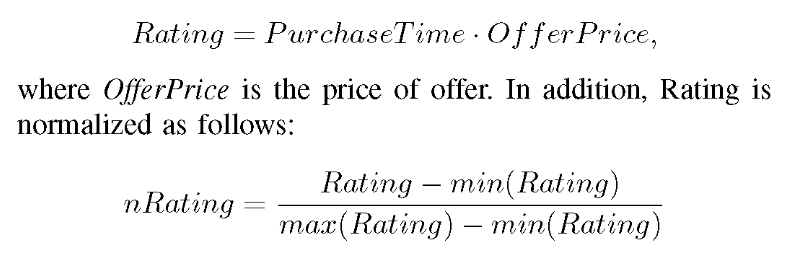
https://doi.org/10.1109/ICCE48956.2021.9352111, 2021  (Pham, C. D., Anh Chu, T., Pham, H. H., Linh Dao, M., Pham, T. S., Hung Trinh, V., & Nguyen, D. H. A recommendation system for offers in telecommunications)
- http://www.utstat.toronto.edu/~brunner/DataAnalysisText/Interactions.pdf

### More advanced methods
- Dimension reduction approaches?

### Usage ratings for year-month

In [179]:
pivot_voice_usage_info = pivot_voice_usage_info.drop(['call_count','duration'], axis=1)
pivot_voice_usage_info

,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
year-month,,,,,,,,,,,,,
event_source.hash,,,,,,,,,,,,,
007400db8afa996e788d23986739f3db,1,0,0,0,0,0,0,0,0,0,0,0,0
009f305bf85a71012c0e343233e611ba,0,0,0,0,3,0,0,0,0,0,0,0,0
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,0,0,0,0,0,0,4,2,0
011adeeaef79aeac706a2e7fc225e8f8,0,0,0,0,0,0,0,0,1,0,0,0,0
0201ee9b60de662cdd16c885f178feea,1,0,0,2,0,0,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe20b17a9573e4b7e765cc3098728f3d,0,0,0,0,0,0,0,0,0,6,0,3,0
fe4e907a21bb03842eb88d0c0d633ca8,0,4,12,12,3,3,8,12,8,3,4,0,0


In [180]:
pivot_voice_usage_info.T.reset_index(drop=True).T
pivot_voice_usage_info.columns=year_month_list

In [181]:
# scaling usage rating
scaler = MinMaxScaler()
for col in year_month_list:
    pivot_voice_usage_info[col] = scaler.fit_transform(pivot_voice_usage_info[col].values.reshape(-1,1))

<AxesSubplot:xlabel='year-month', ylabel='event_source.hash'>

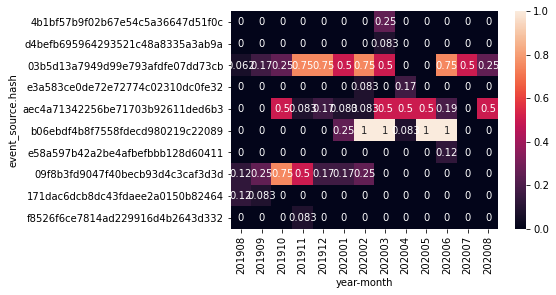

In [182]:
sns.heatmap(pivot_voice_usage_info[year_month_list].sample(n=10), annot=True)

In [183]:
pivot_voice_usage_info['Usage_Rating_Scaled'] = pivot_voice_usage_info[year_month_list].sum(axis=1)/len(year_month_list)
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled
event_source.hash,,,,,,,,,,,,,,
007400db8afa996e788d23986739f3db,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.004808
009f305bf85a71012c0e343233e611ba,0.0000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.019231
00cc5a820586ce291c0fa4c2a99a4816,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2500,0.166667,0.000000,0.032051
011adeeaef79aeac706a2e7fc225e8f8,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.0000,0.000000,0.000000,0.006410
0201ee9b60de662cdd16c885f178feea,0.0625,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0000,0.000000,0.000000,0.043269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe20b17a9573e4b7e765cc3098728f3d,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0000,0.250000,0.000000,0.057692
fe4e907a21bb03842eb88d0c0d633ca8,0.0000,0.333333,1.000000,1.000000,0.250000,0.250000,0.666667,1.000000,0.666667,0.250000,0.2500,0.000000,0.000000,0.435897
ff445f580f7525bd9f1455d6b09704cd,0.0000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.006410


### Finding Outliers

<AxesSubplot:>

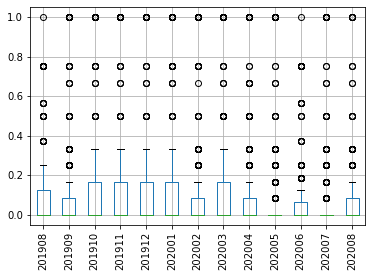

In [184]:
pivot_voice_usage_info.boxplot(column=[int(x) for x in year_month_list], rot=90)

<AxesSubplot:ylabel='year-month'>

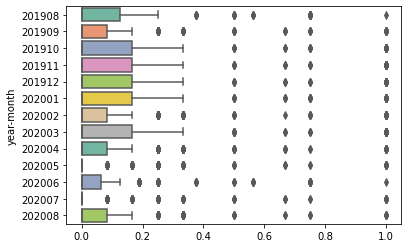

In [185]:
ax = sns.boxplot(data=pivot_voice_usage_info[[int(x) for x in year_month_list]], orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

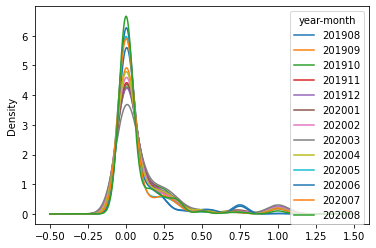

In [186]:
pivot_voice_usage_info[[int(x) for x in year_month_list]].plot(kind = 'density')

## Three quantitative methods commonly used in statistics for the detection of univariate outliers:
- Tukey’s box plot method
- Internally studentized residuals (AKA z-score method)
- Median Absolute Deviation method

### 1) Tukey’s box plot method
- Tukey distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.    
    
- IQR =Q3 - Q1, whereas q3 := 75th quartile and q1 := 25th quartile
- Inner fence = [Q1-1.5*IQR, Q3+1.5*IQR]
- Outer fence = [Q1–3*IQR, Q3+3*IQR]

In [187]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    outliers_prob_indexes = []
    outliers_poss_indexes = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob_indexes.append(index)
            outliers_prob.append(x)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss_indexes.append(index)
            outliers_poss.append(x)
    # returns indexes of the rows with outliers
    return outliers_prob, outliers_prob_indexes, outliers_poss, outliers_poss_indexes

In [188]:
pr_col_threshold = []
po_col_threshold = []
for col in year_month_list:
    pr_col, pr_col_indexes, po_col, po_col_indexes = tukeys_method(pivot_voice_usage_info, int(col))
    pr_col_threshold.append({col: {"threshold": min(pr_col), "count": len(pr_col)}})
    po_col_threshold.append({col: {"threshold": min(po_col), "count": len(po_col)}})
    print()
    print(f"Probable Outliers for {col}---->\n", pr_col)
    print(len(pr_col))
    print()
    print(f"Possible Outliers for {col}----->\n", po_col)
    print(len(po_col))
    print()


Probable Outliers for 201908---->
 [0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5625, 0.75, 0.75, 0.75, 0.75, 0.5625, 0.5625, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 1.0, 0.5625, 0.5, 0.5625, 0.75]
33

Possible Outliers for 201908----->
 [0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.375, 0.375, 0.75, 0.75, 0.5, 0.75, 0.75, 0.375, 0.75, 0.75, 0.5625, 0.75, 0.75, 0.75, 0.75, 0.375, 0.375, 0.5625, 0.5625, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.75, 0.375, 0.375, 1.0, 0.5625, 0.5, 0.5625, 0.75]
40


Probable Outliers for 201909---->
 [0.3333333333333333, 1.0, 0.5, 0.75, 0.3333333333333333, 1.0, 0.3333333333333333, 1.0, 0.5, 0.75, 0.3333333333333333, 0.3333333333333333, 0.75, 0.6666666666666666, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.75, 0.5, 1.0, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.5, 0.75, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 1.0, 0.3333333333333333, 0.6666666666

In [189]:
pr_col_threshold

[{201908: {'threshold': 0.5, 'count': 33}},
 {201909: {'threshold': 0.3333333333333333, 'count': 49}},
 {201910: {'threshold': 0.6666666666666666, 'count': 29}},
 {201911: {'threshold': 0.6666666666666666, 'count': 28}},
 {201912: {'threshold': 0.6666666666666666, 'count': 29}},
 {202001: {'threshold': 0.6666666666666666, 'count': 30}},
 {202002: {'threshold': 0.3333333333333333, 'count': 53}},
 {202003: {'threshold': 0.6666666666666666, 'count': 35}},
 {202004: {'threshold': 0.3333333333333333, 'count': 56}},
 {202005: {'threshold': 0.0, 'count': 517}},
 {202006: {'threshold': 0.25, 'count': 55}},
 {202007: {'threshold': 0.0, 'count': 517}},
 {202008: {'threshold': 0.3333333333333333, 'count': 41}}]

In [190]:
po_col_threshold

[{201908: {'threshold': 0.375, 'count': 40}},
 {201909: {'threshold': 0.25, 'count': 76}},
 {201910: {'threshold': 0.5, 'count': 35}},
 {201911: {'threshold': 0.5, 'count': 35}},
 {201912: {'threshold': 0.5, 'count': 35}},
 {202001: {'threshold': 0.5, 'count': 37}},
 {202002: {'threshold': 0.25, 'count': 85}},
 {202003: {'threshold': 0.5, 'count': 46}},
 {202004: {'threshold': 0.25, 'count': 90}},
 {202005: {'threshold': 0.0, 'count': 517}},
 {202006: {'threshold': 0.1875, 'count': 79}},
 {202007: {'threshold': 0.0, 'count': 517}},
 {202008: {'threshold': 0.25, 'count': 63}}]

### 2) Median Absolute Deviation method
- this method is highly limited as the distributions mean and standard deviation are sensitive to outliers. This means that finding one outlier is dependent on other outliers as every observation directly affects the mean.    
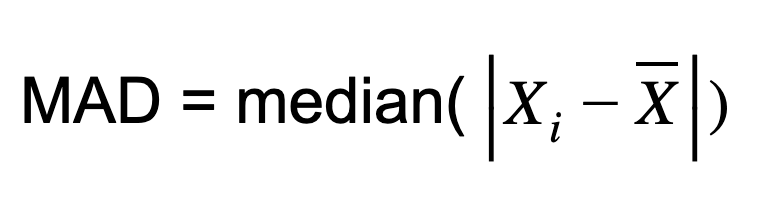

In [191]:
from scipy import stats

# MAD method
def mad_method(df, variable_name):
    #Takes two parameters: dataframe & variable of interest as string
    columns = df.columns
    med = np.median(df, axis = 0)
    mad = np.abs(stats.median_absolute_deviation(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable_name:
            index == item
    for i, v in enumerate(df.loc[:,variable_name]):
        t = (v-med[index])/mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

In [192]:
col_threshold = []
for col in year_month_list:
    outliers = mad_method(pivot_voice_usage_info, int(col))
    outlier_cols = pivot_voice_usage_info[int(col)].iloc[outliers]
    col_threshold.append({col: {"threshold" :min(outlier_cols), "count":len(outliers)}})
    print()
    print(f"Outliers for {col}---->\n", outlier_cols)
    print(len(outliers))


Outliers for 201908---->
 event_source.hash
007400db8afa996e788d23986739f3db    0.0625
0201ee9b60de662cdd16c885f178feea    0.0625
029b57551e576f248ff07c849db52fd6    0.1875
03b5d13a7949d99e793afdfe07dd73cb    0.0625
04ec40da46c6ca65064a371a0a695f74    0.0625
                                     ...  
f50e8a2522301fa447153e007a624011    0.0625
f98f6750211cfdc7fee9a826ff5293b4    0.1875
facfe99fff1a63941380ad952a055621    0.1250
ff7e0f4edb7b39b683b9134af37fc4d3    0.7500
ffd96f173d6cd683bf3384bdc2f99713    0.2500
Name: 201908, Length: 176, dtype: float64
176

Outliers for 201909---->
 event_source.hash
029b57551e576f248ff07c849db52fd6    0.166667
03b5d13a7949d99e793afdfe07dd73cb    0.166667
0480fbc41f1ab2d73ea50c0dda53b89e    0.083333
04ec40da46c6ca65064a371a0a695f74    0.166667
0598ebdbe1c730120b3c5504c9d90a9f    0.083333
                                      ...   
f6f97a90a742d6f3ee157c9e519c7242    0.333333
f852c66e165c8845bf24e759a33e0bfe    0.250000
facfe99fff1a63941380ad952a05562

<ipython-input-191-ab658f4f8d27>:8: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  mad = np.abs(stats.median_absolute_deviation(df))
<ipython-input-191-ab658f4f8d27>:16: RuntimeWarning: divide by zero encountered in double_scalars
  t = (v-med[index])/mad[index]
<ipython-input-191-ab658f4f8d27>:16: RuntimeWarning: invalid value encountered in double_scalars
  t = (v-med[index])/mad[index]


In [193]:
col_threshold

[{201908: {'threshold': 0.0625, 'count': 176}},
 {201909: {'threshold': 0.08333333333333333, 'count': 160}},
 {201910: {'threshold': 0.08333333333333333, 'count': 185}},
 {201911: {'threshold': 0.08333333333333333, 'count': 169}},
 {201912: {'threshold': 0.08333333333333333, 'count': 180}},
 {202001: {'threshold': 0.08333333333333333, 'count': 180}},
 {202002: {'threshold': 0.08333333333333333, 'count': 157}},
 {202003: {'threshold': 0.08333333333333333, 'count': 204}},
 {202004: {'threshold': 0.08333333333333333, 'count': 161}},
 {202005: {'threshold': 0.08333333333333333, 'count': 116}},
 {202006: {'threshold': 0.0625, 'count': 148}},
 {202007: {'threshold': 0.08333333333333333, 'count': 122}},
 {202008: {'threshold': 0.08333333333333333, 'count': 131}}]

In [194]:
sum_outlier = 0
for col in col_threshold:
    for key,val in col.items():
        sum_outlier += val["threshold"]
avg_outlier = sum_outlier / len(col_threshold)
pivot_voice_usage_info["Outlier"]=pivot_voice_usage_info.apply(lambda x : "YES" if x["Usage_Rating_Scaled"]> avg_outlier else "NO", axis=1)
print(avg_outlier)

0.08012820512820513


In [195]:
pivot_voice_usage_info.describe()

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.00000,517.000000,517.000000,517.000000,517.000000
mean,0.083414,0.092682,0.110090,0.104610,0.111380,0.109446,0.099613,0.133462,0.098162,0.07060,0.072171,0.072050,0.067537,0.094248
std,0.175899,0.204634,0.224792,0.223459,0.229260,0.222764,0.221006,0.250105,0.207771,0.18434,0.165762,0.184981,0.158277,0.141924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.004808
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.012821
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.038462
75%,0.125000,0.083333,0.166667,0.166667,0.166667,0.166667,0.083333,0.166667,0.083333,0.00000,0.062500,0.000000,0.083333,0.110577
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.833333


In [196]:
# labling usage bins
bins = [0, 0.33, 0.66,1]
labels = ['LOW','MEDIUM','HIGH']
pivot_voice_usage_info['Usage_Rating_Categorical'] = pd.cut(pivot_voice_usage_info['Usage_Rating_Scaled'], bins=bins, labels=labels)
pivot_voice_usage_info

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,,,,,,
007400db8afa996e788d23986739f3db,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.004808,NO,LOW
009f305bf85a71012c0e343233e611ba,0.0000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.019231,NO,LOW
00cc5a820586ce291c0fa4c2a99a4816,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2500,0.166667,0.000000,0.032051,NO,LOW
011adeeaef79aeac706a2e7fc225e8f8,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.0000,0.000000,0.000000,0.006410,NO,LOW
0201ee9b60de662cdd16c885f178feea,0.0625,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0000,0.000000,0.000000,0.043269,NO,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe20b17a9573e4b7e765cc3098728f3d,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0000,0.250000,0.000000,0.057692,NO,LOW
fe4e907a21bb03842eb88d0c0d633ca8,0.0000,0.333333,1.000000,1.000000,0.250000,0.250000,0.666667,1.000000,0.666667,0.250000,0.2500,0.000000,0.000000,0.435897,YES,MEDIUM
ff445f580f7525bd9f1455d6b09704cd,0.0000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.006410,NO,LOW


In [197]:
# adding category "NO" 
pivot_voice_usage_info['Usage_Rating_Categorical'] = pivot_voice_usage_info['Usage_Rating_Categorical'].cat.add_categories("NO")
pivot_voice_usage_info.loc[pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0, 'Usage_Rating_Categorical'] = "NO"
pivot_voice_usage_info[(pivot_voice_usage_info['Usage_Rating_Scaled'] == 0.0)]

year-month,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical
event_source.hash,,,,,,,,,,,,,,,,


## Combining other features

In [199]:
combined_df = voice_usage_info[["event_source.hash","outgoing_country","Revenue_on_Usage"]]

In [200]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2674
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   event_source.hash  2089 non-null   object
 1   outgoing_country   2089 non-null   object
 2   Revenue_on_Usage   2089 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 65.3+ KB


In [201]:
combined_df = combined_df.groupby('event_source.hash', as_index=False).agg(list)

In [202]:
combined_df["outgoing_country"] = combined_df["outgoing_country"].apply(lambda x:  list(set(x)))

In [203]:
combined_df["Revenue_on_Usage_Cumulative"] = combined_df["Revenue_on_Usage"].apply(lambda x:  sum(x))

In [204]:
combined_df.drop(["Revenue_on_Usage"],axis=1, inplace=True)

In [205]:
combined_df

,event_source.hash,outgoing_country,Revenue_on_Usage_Cumulative
0,007400db8afa996e788d23986739f3db,[U.K.],3033
1,009f305bf85a71012c0e343233e611ba,[Australia - Mobile],234300
2,00cc5a820586ce291c0fa4c2a99a4816,[India],124020
3,011adeeaef79aeac706a2e7fc225e8f8,[Australia - Mobile],1800
4,0201ee9b60de662cdd16c885f178feea,[Italy - Mobile],129300
...,...,...,...
512,fe20b17a9573e4b7e765cc3098728f3d,[Australia - Mobile],442500
513,fe4e907a21bb03842eb88d0c0d633ca8,[India],1057550
514,ff445f580f7525bd9f1455d6b09704cd,[United Arab Emirates],5000
515,ff7e0f4edb7b39b683b9134af37fc4d3,"[Australia - Mobile, Canada, Australia]",2452820


In [206]:
combined_df.to_csv("data/user_profile/VOICE_IDD_Outgoing_Country_and_Revenue.csv")

In [207]:
pivot_voice_usage_info_combined = pivot_voice_usage_info.merge(combined_df, how="left",on="event_source.hash")

In [208]:
pivot_voice_usage_info_combined

,event_source.hash,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Outlier,Usage_Rating_Categorical,outgoing_country,Revenue_on_Usage_Cumulative
0,007400db8afa996e788d23986739f3db,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.004808,NO,LOW,[U.K.],3033
1,009f305bf85a71012c0e343233e611ba,0.0000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.019231,NO,LOW,[Australia - Mobile],234300
2,00cc5a820586ce291c0fa4c2a99a4816,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2500,0.166667,0.000000,0.032051,NO,LOW,[India],124020
3,011adeeaef79aeac706a2e7fc225e8f8,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.0000,0.000000,0.000000,0.006410,NO,LOW,[Australia - Mobile],1800
4,0201ee9b60de662cdd16c885f178feea,0.0625,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0000,0.000000,0.000000,0.043269,NO,LOW,[Italy - Mobile],129300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,fe20b17a9573e4b7e765cc3098728f3d,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0000,0.250000,0.000000,0.057692,NO,LOW,[Australia - Mobile],442500
513,fe4e907a21bb03842eb88d0c0d633ca8,0.0000,0.333333,1.000000,1.000000,0.250000,0.250000,0.666667,1.000000,0.666667,0.250000,0.2500,0.000000,0.000000,0.435897,YES,MEDIUM,[India],1057550
514,ff445f580f7525bd9f1455d6b09704cd,0.0000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.006410,NO,LOW,[United Arab Emirates],5000
515,ff7e0f4edb7b39b683b9134af37fc4d3,0.7500,0.000000,0.083333,0.083333,0.333333,1.000000,1.000000,1.000000,0.500000,0.333333,0.2500,1.000000,0.666667,0.538462,YES,MEDIUM,"[Australia - Mobile, Canada, Australia]",2452820


### No of outliers

In [149]:
pivot_voice_usage_info_combined["Outlier"].value_counts()

NO     354
YES    163
Name: Outlier, dtype: int64

In [209]:
pivot_voice_usage_info_combined.to_csv("data/user_profile/VOICE_IDD_Outgoing_Usage_Categorical.csv")

# Phase 2

## Binnig by Location 

- 1. group by location columns
- 2. Bin by location and get counts

In [62]:
voice_usage_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2674
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   event_source.hash  2089 non-null   object
 1   year-month         2089 non-null   int64 
 2   outgoing_country   2089 non-null   object
 3   call_count         2089 non-null   int64 
 4   duration           2089 non-null   int64 
 5   Revenue_on_Usage   2089 non-null   int64 
 6   RTOM_CODE          2089 non-null   object
 7   LOCATION_CODE      2089 non-null   object
 8   MSAN               2089 non-null   object
 9   EQUP_ID            2089 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 179.5+ KB


In [63]:
# bucketing by location
voice_location_info = voice_usage_info
voice_location_info['Location_Identifier'] = voice_location_info['MSAN'].astype(str)+ voice_location_info['LOCATION_CODE'].astype(str) +voice_location_info['EQUP_ID'].astype(str) 
voice_location_info

,event_source.hash,year-month,outgoing_country,call_count,duration,Revenue_on_Usage,RTOM_CODE,LOCATION_CODE,MSAN,EQUP_ID,Location_Identifier
0,b1e1f92a2d017ea8f0b457533636ed33,202001,Canada,2,460,37567,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
2,d4eec8e7da1cdd41ad17797dee3b26da,202001,Australia - Mobile,1,12,3600,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
3,92691c288626b57a2d5e9bb3b03b143e,201911,Oman-Mobile,1,156,85800,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
4,1cfa0cd56534abc01792cc73fbc771de,202001,Canada,3,538,43937,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
5,61d67d49f1e8747af7fbbd1232e97eef,202004,Canada,1,274,22377,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
...,...,...,...,...,...,...,...,...,...,...,...
2670,71f750d1ac24343ca3a3de5e197af6ec,201909,Australia - Mobile,1,76,22800,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
2671,71f750d1ac24343ca3a3de5e197af6ec,201910,Australia - Mobile,1,9,2700,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
2672,71f750d1ac24343ca3a3de5e197af6ec,202001,Australia - Mobile,1,153,45900,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003
2673,db7e4b8a8752e0a0af834f0e6eab8a0b,201909,UK - Mobile,1,21,6300,R-NTB,PC-AGT-NODE,MSAG5200-ISL,48003,MSAG5200-ISLPC-AGT-NODE48003


In [64]:
voice_location_info = voice_location_info.drop_duplicates("event_source.hash", keep="last")
voice_location_info.shape

(517, 11)

In [65]:
user_location = voice_location_info[['event_source.hash','Location_Identifier']]
user_location

,event_source.hash,Location_Identifier
2,d4eec8e7da1cdd41ad17797dee3b26da,MSAG5200-ISLPC-AGT-NODE48003
3,92691c288626b57a2d5e9bb3b03b143e,MSAG5200-ISLPC-AGT-NODE48003
4,1cfa0cd56534abc01792cc73fbc771de,MSAG5200-ISLPC-AGT-NODE48003
5,61d67d49f1e8747af7fbbd1232e97eef,MSAG5200-ISLPC-AGT-NODE48003
6,e151cb14a07999a8cee1bd15d2545cd8,MSAG5200MGE-NODE42838
...,...,...
2667,7dd947f0a15a2481b7fee96c88187c4b,MSAG5200-ISLMT-AVR-NODE46716
2669,5b36830364aac0e222251e82733bc585,MSAG5200-ISLPC-AGT-NODE48003
2672,71f750d1ac24343ca3a3de5e197af6ec,MSAG5200-ISLPC-AGT-NODE48003
2673,db7e4b8a8752e0a0af834f0e6eab8a0b,MSAG5200-ISLPC-AGT-NODE48003


In [66]:
user_location.to_csv("data/user_profile/VOICE_IDD_OUTGOING_Locations_of_Users.csv")

In [67]:
voice_location_info["User_Count"] = 1
voice_gropued_by_locations = voice_location_info.groupby(['Location_Identifier'], axis=0,as_index=False).sum()
voice_gropued_by_locations = voice_gropued_by_locations[['Location_Identifier','User_Count']]

<ipython-input-67-46e54884d952>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_location_info["User_Count"] = 1


In [68]:
voice_gropued_by_locations

,Location_Identifier,User_Count
0,C300MHT-NE-NODE815246,2
1,C300MIDH-IDJ-NODE1106554,9
2,C300MKI-NODE1066816,17
3,C300MNW-MEE-NODE1888775,7
4,C300MTP-NODE870091,2
5,C300MVH-NODE987404,1
6,MA5603TAD-SRV-NODE1022499,2
7,MSAG5200-ISLBZ-NODE43588,3
8,MSAG5200-ISLGE-NODE557798,2
9,MSAG5200-ISLHC-NAP-NODE47872,2


In [69]:
voice_gropued_by_locations.to_csv("data/user_profile/VOICE_IDD_Outgoing_Users_Count_by_Location.csv")

<AxesSubplot:>

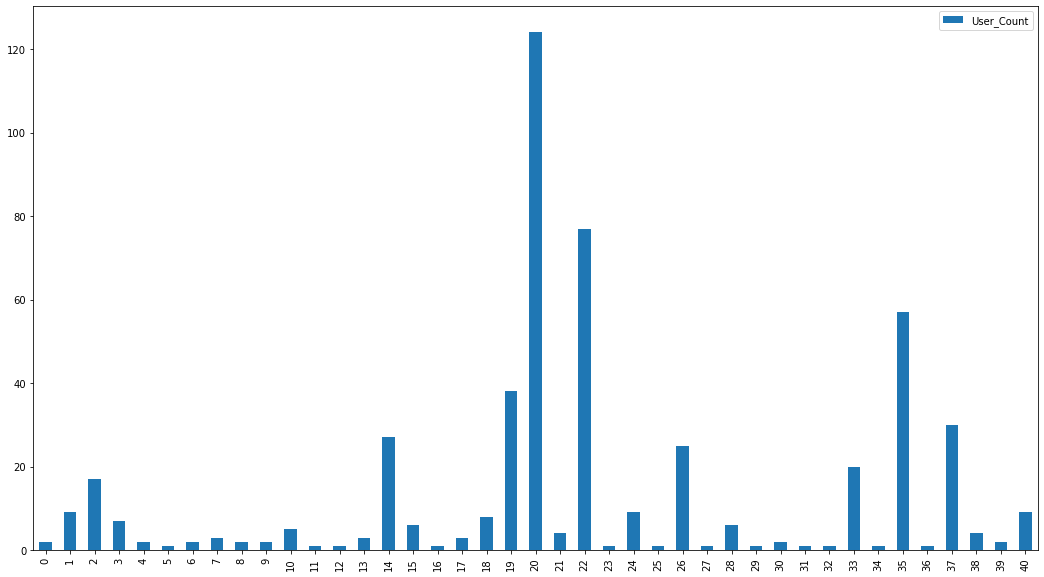

In [70]:
voice_gropued_by_locations.plot(kind="bar", figsize=(18,10),xticks=voice_gropued_by_locations.index)